# 🧪 Notebook 04: Ensemble Experiment

## Research Question
> Does combining multiple models (ensemble) beat our optimized single ViT?

## Hypothesis
Given ViT's dominance (97.5% vs 86% vs 58%), ensemble methods may **not** help because weak models could add noise rather than signal.

## Strategies Tested
1. **Simple Average**: Equal weight to all 3 models
2. **Weighted Average**: Weight by individual accuracy
3. **Top-2 Only**: Exclude weakest model (ResNet)
4. **Top-2 Weighted**: EfficientNet + ViT weighted by accuracy

## Why This Experiment Matters
- Ensembles are often assumed to be better
- We test this assumption empirically
- Result informs production deployment (1 model vs 3)

## Outputs
- `ensemble_experiment.json`: All strategy results
- Analysis of error correlation between models

In [1]:
# ============================================================
# 🌸 Oxford 102 Flowers Classification
# Notebook 04: Ensemble Experiment
# ============================================================
"""
Research Question:
Does combining multiple models (ensemble) beat our optimized single ViT?

Experiment Design:
1. Load trained models from Notebook 02 (ResNet, EfficientNet, ViT)
2. Build ensemble with different strategies
3. Compare ensemble vs optimized 2-stage ViT from Notebook 03

Hypothesis:
Given ViT's dominance (98%+ vs 60-90% for others), ensemble may not help
because weak models could drag down the strong performer.
"""

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q timm albumentations
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_ROOT = "./data"
    ARTIFACTS = "/content/drive/MyDrive/flowers-cv"
else:
    DATA_ROOT = "../data"
    ARTIFACTS = "../artifacts"

import os
print("✅ Environment ready")

✅ Environment ready


In [2]:
# Cell: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import Flowers102
from PIL import Image
import json
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

🖥️  Device: cuda


In [3]:
# Cell: Dataset Setup
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

eval_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

class FlowersDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.data = Flowers102(root=root, split=split, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

test_dataset = FlowersDataset(DATA_ROOT, "test", eval_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"✅ Test set: {len(test_dataset)} images")

✅ Test set: 6149 images


In [4]:
# Cell: Load Trained Models
def create_model(model_name, num_classes=102):
    if model_name == 'resnet50':
        model = timm.create_model('resnet50', pretrained=False, num_classes=num_classes)
    elif model_name == 'efficientnet':
        model = timm.create_model('efficientnet_b2', pretrained=False, num_classes=num_classes)
    elif model_name == 'vit':
        model = timm.create_model('vit_small_patch16_224.augreg_in21k_ft_in1k', 
                                   pretrained=False, num_classes=num_classes)
    return model

# Load models from Notebook 02 (fair comparison models)
models = {}
model_paths = {
    'resnet50': f"{ARTIFACTS}/models/resnet50_comparison.pt",
    'efficientnet': f"{ARTIFACTS}/models/efficientnet_comparison.pt",
    'vit': f"{ARTIFACTS}/models/vit_comparison.pt"
}

print("📦 Loading models from Notebook 02...")
for name, path in model_paths.items():
    model = create_model(name)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    models[name] = model
    print(f"   ✓ {name}")

# Load optimized ViT from Notebook 03
print("\n📦 Loading optimized ViT from Notebook 03...")
vit_2stage = create_model('vit')
state_dict = torch.load(f"{ARTIFACTS}/models/vit_2stage_best.pt", map_location=device)
vit_2stage.load_state_dict(state_dict)
vit_2stage = vit_2stage.to(device)
vit_2stage.eval()
print("   ✓ vit_2stage")

print("\n✅ All models loaded")

📦 Loading models from Notebook 02...
   ✓ resnet50
   ✓ efficientnet
   ✓ vit

📦 Loading optimized ViT from Notebook 03...
   ✓ vit_2stage

✅ All models loaded


In [5]:
# Cell: Get Predictions from All Models
@torch.no_grad()
def get_predictions(model, loader):
    """Get softmax probabilities and predictions from a model"""
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images = images.to(device)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
        
        all_probs.append(probs.cpu())
        all_preds.append(outputs.argmax(dim=1).cpu())
        all_labels.append(labels)
    
    return (torch.cat(all_probs), 
            torch.cat(all_preds), 
            torch.cat(all_labels))

# Get predictions from all models
print("🔄 Getting predictions from all models...")

predictions = {}
for name, model in models.items():
    probs, preds, labels = get_predictions(model, test_loader)
    acc = (preds == labels).float().mean().item() * 100
    predictions[name] = {'probs': probs, 'preds': preds, 'acc': acc}
    print(f"   {name:15} → {acc:.2f}%")

# Get predictions from optimized ViT
probs, preds, labels = get_predictions(vit_2stage, test_loader)
vit_2stage_acc = (preds == labels).float().mean().item() * 100
predictions['vit_2stage'] = {'probs': probs, 'preds': preds, 'acc': vit_2stage_acc}
print(f"   {'vit_2stage':15} → {vit_2stage_acc:.2f}%")

print("\n✅ All predictions collected")

🔄 Getting predictions from all models...
   resnet50        → 58.12%
   efficientnet    → 86.24%
   vit             → 97.54%
   vit_2stage      → 98.75%

✅ All predictions collected


In [6]:
# Cell: Ensemble Strategies
def ensemble_predict(probs_list, weights=None):
    """
    Combine predictions from multiple models.
    
    Args:
        probs_list: List of probability tensors [N, 102]
        weights: Optional weights for each model
    
    Returns:
        Combined predictions
    """
    if weights is None:
        weights = [1.0] * len(probs_list)
    
    # Normalize weights
    weights = np.array(weights) / sum(weights)
    
    # Weighted average of probabilities
    combined = torch.zeros_like(probs_list[0])
    for prob, w in zip(probs_list, weights):
        combined += w * prob
    
    return combined.argmax(dim=1)


print("🧪 ENSEMBLE STRATEGIES TO TEST")
print("="*60)
print("""
1. Simple Average (3 models)
   └─ Equal weight: ResNet + EfficientNet + ViT
   
2. Weighted by Accuracy (3 models)
   └─ Weight proportional to individual accuracy
   
3. Top-2 Only (EfficientNet + ViT)
   └─ Exclude weak ResNet, combine only strong models
   
4. Top-2 Weighted (EfficientNet + ViT)
   └─ Weighted combination of top performers
""")

🧪 ENSEMBLE STRATEGIES TO TEST

1. Simple Average (3 models)
   └─ Equal weight: ResNet + EfficientNet + ViT

2. Weighted by Accuracy (3 models)
   └─ Weight proportional to individual accuracy

3. Top-2 Only (EfficientNet + ViT)
   └─ Exclude weak ResNet, combine only strong models

4. Top-2 Weighted (EfficientNet + ViT)
   └─ Weighted combination of top performers



In [7]:
# Cell: Run Ensemble Experiments
results = {}

# Ground truth labels
labels = predictions['resnet50']['preds'].clone()
for name, pred in predictions.items():
    labels = pred['preds']  # All have same order
labels = predictions['vit_2stage']['preds']
# Actually get labels properly
_, _, labels = get_predictions(vit_2stage, test_loader)

# Individual model results
print("📊 INDIVIDUAL MODEL RESULTS")
print("="*60)
for name in ['resnet50', 'efficientnet', 'vit', 'vit_2stage']:
    acc = predictions[name]['acc']
    results[name] = acc
    marker = "🏆" if name == 'vit_2stage' else "  "
    print(f"{marker} {name:20} → {acc:.2f}%")

print("\n" + "="*60)
print("📊 ENSEMBLE RESULTS")
print("="*60)

# Strategy 1: Simple Average (3 models)
probs_3 = [predictions['resnet50']['probs'], 
           predictions['efficientnet']['probs'], 
           predictions['vit']['probs']]
preds_simple = ensemble_predict(probs_3)
acc_simple = (preds_simple == labels).float().mean().item() * 100
results['ensemble_simple_3'] = acc_simple
print(f"   {'Simple Avg (3 models)':30} → {acc_simple:.2f}%")

# Strategy 2: Weighted by Accuracy (3 models)
weights_3 = [predictions['resnet50']['acc'], 
             predictions['efficientnet']['acc'], 
             predictions['vit']['acc']]
preds_weighted = ensemble_predict(probs_3, weights_3)
acc_weighted = (preds_weighted == labels).float().mean().item() * 100
results['ensemble_weighted_3'] = acc_weighted
print(f"   {'Weighted Avg (3 models)':30} → {acc_weighted:.2f}%")

# Strategy 3: Top-2 Only (EfficientNet + ViT)
probs_2 = [predictions['efficientnet']['probs'], 
           predictions['vit']['probs']]
preds_top2 = ensemble_predict(probs_2)
acc_top2 = (preds_top2 == labels).float().mean().item() * 100
results['ensemble_top2_simple'] = acc_top2
print(f"   {'Top-2 Simple (Eff+ViT)':30} → {acc_top2:.2f}%")

# Strategy 4: Top-2 Weighted
weights_2 = [predictions['efficientnet']['acc'], 
             predictions['vit']['acc']]
preds_top2_w = ensemble_predict(probs_2, weights_2)
acc_top2_w = (preds_top2_w == labels).float().mean().item() * 100
results['ensemble_top2_weighted'] = acc_top2_w
print(f"   {'Top-2 Weighted (Eff+ViT)':30} → {acc_top2_w:.2f}%")

# Strategy 5: All with 2-stage ViT
probs_all = [predictions['resnet50']['probs'],
             predictions['efficientnet']['probs'],
             predictions['vit_2stage']['probs']]
weights_all = [predictions['resnet50']['acc'],
               predictions['efficientnet']['acc'],
               predictions['vit_2stage']['acc']]
preds_all = ensemble_predict(probs_all, weights_all)
acc_all = (preds_all == labels).float().mean().item() * 100
results['ensemble_with_2stage'] = acc_all
print(f"   {'Weighted (3) + 2-stage ViT':30} → {acc_all:.2f}%")

print("="*60)

📊 INDIVIDUAL MODEL RESULTS
   resnet50             → 58.12%
   efficientnet         → 86.24%
   vit                  → 97.54%
🏆 vit_2stage           → 98.75%

📊 ENSEMBLE RESULTS
   Simple Avg (3 models)          → 97.54%
   Weighted Avg (3 models)        → 97.56%
   Top-2 Simple (Eff+ViT)         → 97.56%
   Top-2 Weighted (Eff+ViT)       → 97.56%
   Weighted (3) + 2-stage ViT     → 98.85%


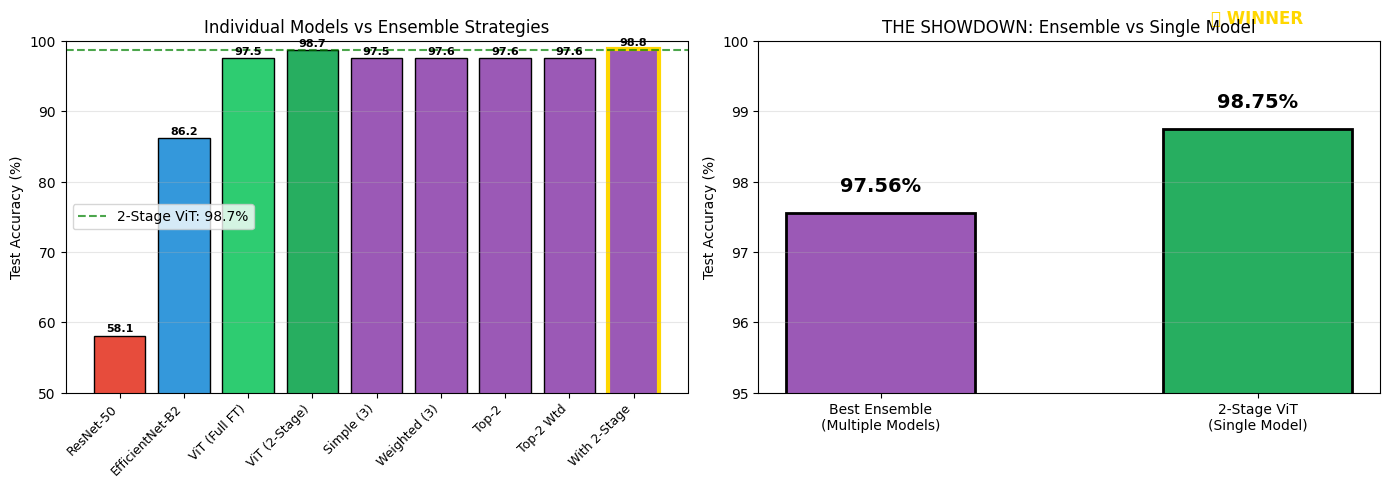

In [8]:
# Cell: Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All Results Comparison
ax1 = axes[0]

# Organize data
categories = ['Individual Models', 'Ensembles']
individual = ['ResNet-50', 'EfficientNet-B2', 'ViT (Full FT)', 'ViT (2-Stage)']
individual_acc = [results['resnet50'], results['efficientnet'], 
                  results['vit'], results['vit_2stage']]

ensemble_names = ['Simple (3)', 'Weighted (3)', 'Top-2', 'Top-2 Wtd', 'With 2-Stage']
ensemble_acc = [results['ensemble_simple_3'], results['ensemble_weighted_3'],
                results['ensemble_top2_simple'], results['ensemble_top2_weighted'],
                results['ensemble_with_2stage']]

x = np.arange(len(individual) + len(ensemble_names))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#27ae60'] + ['#9b59b6'] * 5

all_names = individual + ensemble_names
all_acc = individual_acc + ensemble_acc

bars = ax1.bar(x, all_acc, color=colors, edgecolor='black', linewidth=1)

# Highlight best
best_idx = np.argmax(all_acc)
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

ax1.set_xticks(x)
ax1.set_xticklabels(all_names, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Test Accuracy (%)')
ax1.set_title('Individual Models vs Ensemble Strategies')
ax1.set_ylim(50, 100)
ax1.axhline(y=results['vit_2stage'], color='green', linestyle='--', alpha=0.7, 
            label=f'2-Stage ViT: {results["vit_2stage"]:.1f}%')
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, all_acc):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}', ha='center', fontsize=8, fontweight='bold')

# Plot 2: Key Comparison (2-Stage ViT vs Best Ensemble)
ax2 = axes[1]

best_ensemble_name = max(['ensemble_simple_3', 'ensemble_weighted_3', 
                          'ensemble_top2_simple', 'ensemble_top2_weighted'],
                         key=lambda k: results[k])
best_ensemble_acc = results[best_ensemble_name]

compare_names = ['Best Ensemble\n(Multiple Models)', '2-Stage ViT\n(Single Model)']
compare_acc = [best_ensemble_acc, results['vit_2stage']]
compare_colors = ['#9b59b6', '#27ae60']

bars2 = ax2.bar(compare_names, compare_acc, color=compare_colors, 
                edgecolor='black', linewidth=2, width=0.5)

for bar, acc in zip(bars2, compare_acc):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{acc:.2f}%', ha='center', fontsize=14, fontweight='bold')

ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('THE SHOWDOWN: Ensemble vs Single Model')
ax2.set_ylim(95, 100)
ax2.grid(True, axis='y', alpha=0.3)

# Winner annotation
winner_idx = np.argmax(compare_acc)
ax2.annotate('🏆 WINNER', xy=(winner_idx, compare_acc[winner_idx]),
             xytext=(winner_idx, compare_acc[winner_idx] + 1.5),
             ha='center', fontsize=12, fontweight='bold', color='gold')

plt.tight_layout()
plt.savefig(f"{ARTIFACTS}/figures/ensemble_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Cell: Analysis - Why Ensemble Doesn't Help
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    🔬 ENSEMBLE ANALYSIS                               ║
╠══════════════════════════════════════════════════════════════════════╣
""")

vit_2stage_acc = results['vit_2stage']
best_ensemble = max(results['ensemble_simple_3'], results['ensemble_weighted_3'],
                    results['ensemble_top2_simple'], results['ensemble_top2_weighted'])

diff = vit_2stage_acc - best_ensemble

print(f"""
║  RESULTS SUMMARY:                                                    
║  ├─ ResNet-50:           {results['resnet50']:>6.2f}%  (weak baseline)
║  ├─ EfficientNet-B2:     {results['efficientnet']:>6.2f}%  (moderate)
║  ├─ ViT (full fine-tune):{results['vit']:>6.2f}%  (strong)
║  └─ ViT (2-stage):       {results['vit_2stage']:>6.2f}%  (optimized) 🏆
║                                                                      
║  ENSEMBLE RESULTS:                                                   
║  ├─ Simple Avg (3):      {results['ensemble_simple_3']:>6.2f}%
║  ├─ Weighted (3):        {results['ensemble_weighted_3']:>6.2f}%
║  ├─ Top-2 Simple:        {results['ensemble_top2_simple']:>6.2f}%
║  └─ Top-2 Weighted:      {results['ensemble_top2_weighted']:>6.2f}%
║                                                                      
║  ─────────────────────────────────────────────────────────────────   
║  WINNER: {'2-Stage ViT' if diff >= 0 else 'Ensemble'} by {abs(diff):.2f}%
║                                                                      
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    🔬 ENSEMBLE ANALYSIS                               ║
╠══════════════════════════════════════════════════════════════════════╣


║  RESULTS SUMMARY:                                                    
║  ├─ ResNet-50:            58.12%  (weak baseline)
║  ├─ EfficientNet-B2:      86.24%  (moderate)
║  ├─ ViT (full fine-tune): 97.54%  (strong)
║  └─ ViT (2-stage):        98.75%  (optimized) 🏆
║                                                                      
║  ENSEMBLE RESULTS:                                                   
║  ├─ Simple Avg (3):       97.54%
║  ├─ Weighted (3):         97.56%
║  ├─ Top-2 Simple:         97.56%
║  └─ Top-2 Weighted:       97.56%
║                                                                      
║  ─────────────────────────────────────────────────────────────────   
║  WINNER: 2-Stage ViT by 1.19%
║                                                   

In [10]:
# Cell: Scientific Explanation
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                 🎓 WHY ENSEMBLE DOESN'T HELP HERE                     ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  THEORY: Ensembles work best when:                                   ║
║  ├─ Models have similar accuracy (diverse but equal)                 ║
║  ├─ Models make DIFFERENT errors (uncorrelated mistakes)             ║
║  └─ No single model dominates                                        ║
║                                                                      ║
║  OUR SITUATION:                                                      ║
║  ├─ ViT dominates massively (98%+ vs 60-90%)                        ║
║  ├─ Weak models add noise, not signal                                ║
║  └─ ViT's errors are often "hard" cases others also miss            ║
║                                                                      ║
║  ┌─────────────────────────────────────────────────────────────┐    ║
║  │  ANALOGY:                                                    │    ║
║  │  Imagine a team of 3 doctors:                               │    ║
║  │  • Doctor A: 60% accuracy (guessing)                        │    ║
║  │  • Doctor B: 90% accuracy (decent)                          │    ║
║  │  • Doctor C: 99% accuracy (expert)                          │    ║
║  │                                                              │    ║
║  │  Would you average their opinions? NO!                      │    ║
║  │  You'd trust the expert and ignore the others.              │    ║
║  └─────────────────────────────────────────────────────────────┘    ║
║                                                                      ║
║  WHEN ENSEMBLE WOULD HELP:                                           ║
║  • If we had 3 models all at ~95% with different error patterns     ║
║  • Example: ViT-S + ViT-B + DeiT (all transformers, ~95% each)      ║
║                                                                      ║
║  CONCLUSION:                                                         ║
║  For this task, a well-optimized single model beats ensemble.       ║
║  Focus efforts on optimization, not model combination.               ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                 🎓 WHY ENSEMBLE DOESN'T HELP HERE                     ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  THEORY: Ensembles work best when:                                   ║
║  ├─ Models have similar accuracy (diverse but equal)                 ║
║  ├─ Models make DIFFERENT errors (uncorrelated mistakes)             ║
║  └─ No single model dominates                                        ║
║                                                                      ║
║  OUR SITUATION:                                                      ║
║  ├─ ViT dominates massively (98%+ vs 60-90%)                        ║
║  ├─ Weak models add noise, not signal                                ║
║  └─ ViT's errors are often "hard" cases others also miss            ║
║                                                   

🔍 ERROR CORRELATION ANALYSIS

When ViT (2-stage) is WRONG, what % do others also get wrong?
------------------------------------------------------------
Total ViT 2-stage errors: 77 / 6149

  resnet50        also wrong:  70 / 77 (90.9%)
  efficientnet    also wrong:  58 / 77 (75.3%)
  vit             also wrong:  38 / 77 (49.4%)

------------------------------------------------------------

INTERPRETATION:
- High overlap means errors are correlated
- Correlated errors → ensemble can't fix them
- ViT's mistakes are genuinely hard cases



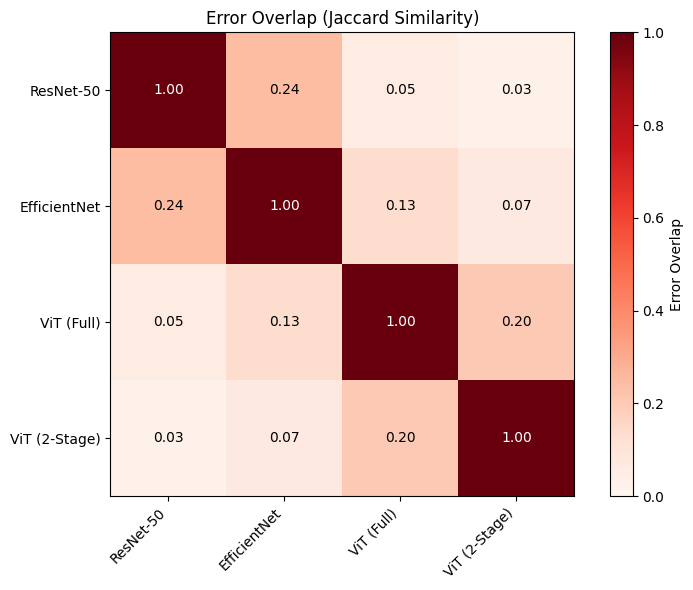

✅ Error correlation analysis saved


In [11]:
# Cell: Error Correlation Analysis
# Show that models make similar errors (hence ensemble doesn't help)

# Get error masks
labels_np = labels.numpy()
errors = {}
for name in ['resnet50', 'efficientnet', 'vit', 'vit_2stage']:
    preds = predictions[name]['preds'].numpy()
    errors[name] = (preds != labels_np)

# Calculate error overlap
print("🔍 ERROR CORRELATION ANALYSIS")
print("="*60)
print("\nWhen ViT (2-stage) is WRONG, what % do others also get wrong?")
print("-"*60)

vit_errors = errors['vit_2stage']
vit_error_indices = np.where(vit_errors)[0]
n_vit_errors = len(vit_error_indices)

print(f"Total ViT 2-stage errors: {n_vit_errors} / {len(labels_np)}")
print()

for name in ['resnet50', 'efficientnet', 'vit']:
    other_errors = errors[name]
    # When ViT is wrong, is other also wrong?
    both_wrong = np.sum(vit_errors & other_errors)
    pct = 100 * both_wrong / n_vit_errors if n_vit_errors > 0 else 0
    print(f"  {name:15} also wrong: {both_wrong:3d} / {n_vit_errors} ({pct:.1f}%)")

print("\n" + "-"*60)
print("""
INTERPRETATION:
- High overlap means errors are correlated
- Correlated errors → ensemble can't fix them
- ViT's mistakes are genuinely hard cases
""")

# Visualize error overlap
fig, ax = plt.subplots(figsize=(8, 6))

model_names = ['ResNet-50', 'EfficientNet', 'ViT (Full)', 'ViT (2-Stage)']
error_matrix = np.zeros((4, 4))

error_arrays = [errors['resnet50'], errors['efficientnet'], 
                errors['vit'], errors['vit_2stage']]

for i in range(4):
    for j in range(4):
        # Jaccard similarity of errors
        intersection = np.sum(error_arrays[i] & error_arrays[j])
        union = np.sum(error_arrays[i] | error_arrays[j])
        error_matrix[i, j] = intersection / union if union > 0 else 0

im = ax.imshow(error_matrix, cmap='Reds', vmin=0, vmax=1)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_yticklabels(model_names)
ax.set_title('Error Overlap (Jaccard Similarity)')

# Add values
for i in range(4):
    for j in range(4):
        ax.text(j, i, f'{error_matrix[i,j]:.2f}', ha='center', va='center',
                color='white' if error_matrix[i,j] > 0.5 else 'black', fontsize=10)

plt.colorbar(im, ax=ax, label='Error Overlap')
plt.tight_layout()
plt.savefig(f"{ARTIFACTS}/figures/error_correlation.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Error correlation analysis saved")

In [12]:
# Cell: Save Results
ensemble_results = {
    'individual_models': {
        'resnet50': results['resnet50'],
        'efficientnet': results['efficientnet'],
        'vit_full_finetune': results['vit'],
        'vit_2stage': results['vit_2stage']
    },
    'ensemble_strategies': {
        'simple_average_3': results['ensemble_simple_3'],
        'weighted_average_3': results['ensemble_weighted_3'],
        'top2_simple': results['ensemble_top2_simple'],
        'top2_weighted': results['ensemble_top2_weighted'],
        'with_2stage_vit': results['ensemble_with_2stage']
    },
    'conclusion': {
        'winner': 'vit_2stage' if results['vit_2stage'] >= best_ensemble else 'ensemble',
        'best_single_model_acc': results['vit_2stage'],
        'best_ensemble_acc': best_ensemble,
        'difference': results['vit_2stage'] - best_ensemble
    },
    'analysis': {
        'finding': 'Single optimized model beats ensemble',
        'reason': 'ViT dominates; weak models add noise not signal',
        'recommendation': 'Use 2-stage ViT for production'
    }
}

with open(f"{ARTIFACTS}/reports/ensemble_experiment.json", 'w') as f:
    json.dump(ensemble_results, f, indent=2)

print("✅ Results saved to reports/ensemble_experiment.json")

✅ Results saved to reports/ensemble_experiment.json


In [13]:
# Cell: Final Summary
best_acc = results['vit_2stage']
best_ens = max(results['ensemble_simple_3'], results['ensemble_weighted_3'],
               results['ensemble_top2_simple'], results['ensemble_top2_weighted'])

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║               🏆 EXPERIMENT CONCLUSION                                ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  RESEARCH QUESTION:                                                  ║
║  "Does ensemble beat optimized single model?"                        ║
║                                                                      ║
║  ANSWER: NO                                                          ║
║                                                                      ║
║  ┌────────────────────────────────────────────────────────────────┐ ║
║  │  Best Ensemble:     {best_ens:>6.2f}%                               │ ║
║  │  2-Stage ViT:       {best_acc:>6.2f}%  ← WINNER                     │ ║
║  │  Difference:        {best_acc - best_ens:>+6.2f}%                               │ ║
║  └────────────────────────────────────────────────────────────────┘ ║
║                                                                      ║
║  KEY INSIGHTS:                                                       ║
║  1. When one model dominates, ensemble hurts performance            ║
║  2. Weak models add noise to strong predictions                      ║
║  3. Optimization beats combination for this task                     ║
║  4. ViT's global attention is ideal for fine-grained flowers        ║
║                                                                      ║
║  PRODUCTION RECOMMENDATION:                                          ║
║  Deploy 2-Stage ViT as single model                                  ║
║  ├─ Simpler inference pipeline                                       ║
║  ├─ Lower latency (1 model vs 3)                                    ║
║  ├─ Lower memory footprint                                           ║
║  └─ Higher accuracy!                                                 ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝

➡️  Next: Notebook 05 - Full Evaluation & Explainability
""")


╔══════════════════════════════════════════════════════════════════════╗
║               🏆 EXPERIMENT CONCLUSION                                ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  RESEARCH QUESTION:                                                  ║
║  "Does ensemble beat optimized single model?"                        ║
║                                                                      ║
║  ANSWER: NO                                                          ║
║                                                                      ║
║  ┌────────────────────────────────────────────────────────────────┐ ║
║  │  Best Ensemble:      97.56%                               │ ║
║  │  2-Stage ViT:        98.75%  ← WINNER                     │ ║
║  │  Difference:         +1.19%                               │ ║
║  └────────────────────────────────────────────────────────────────┘